### Install libraries

In [1]:
%tensorflow_version 2.x

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [3]:
!pip install boto3 botocore opencv-python matplotlib seaborn

     |████████████████████████████████| 132 kB 4.3 MB/s 
     |████████████████████████████████| 8.7 MB 16.6 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 138 kB 86.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


### Import libraries

In [4]:
import os
import json
import gc
import os.path as osp
import boto3
import botocore
import cv2
import yaml
import time
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from random import randint
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Define environmet variables and constants

In [5]:
with open("config.yaml", "r") as stream:
    try:
        config = yaml.safe_load(stream)        
    except yaml.YAMLError as e:
        print(e)

# Define width and length of images
img_w = img_h = 300
image_path = "output/"

### Remove previous files

In [6]:
! rm -rf output

### Copy images from S3

In [7]:
s3 = boto3.resource("s3", 
                    aws_access_key_id = config["S3"]["AWS_ACCESS_KEY_ID"],
                    aws_secret_access_key = config["S3"]["AWS_SECRET_ACCESS_KEY"]
                    )
bucket = s3.Bucket(config["S3"]["BUCKET"])

for bucket_object in bucket.objects.all():
    try:
        filename = bucket_object.key.strip()
        if filename.startswith(image_path) and not(filename.endswith(".json")):
            if len(filename.split('/')) == 4:
                _, folder, gemstone, name = filename.split('/')
                # Check if is a file
                if name != '':
                    path = "/".join(filename.split("/")[0:3])
                    os.makedirs(path, exist_ok=True)
                    bucket.download_file(filename, filename)
    except Exception as e:
        print("Can't download file: " + filename)
        print(e)

### Load and prepare images

In [8]:
def load_images(path: str):
    images, labels = [], []

    # Navigate from data directory
    for root, dirs, files in os.walk(path):
        gemstone_name = osp.basename(root)
        if len(files) >= 1:
            for file in files:
                labels.append(gemstone_name)
                try:
                    # Read image with cv
                    image = cv2.imread(root + '/' + file)
                    # Resize images
                    image = cv2.resize(image, (img_w , img_h))
                    # Convert image from default BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    images.append(image)
                except Exception as e:
                    print("Failes to process image with error: " + str(file))
    return (np.array(images), np.array(labels))


In [9]:
images, labels = load_images(image_path)
print("{0} gemstone with {1} images".format(len(np.unique(labels)), len(images)))

80 gemstone with 4382 images


### Distribution of images by gemstone

[[]]

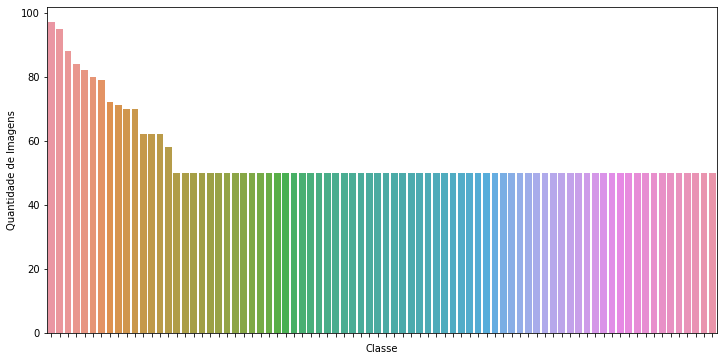

In [10]:
s_labels = pd.Series(labels)
labels_df = s_labels.value_counts().rename_axis('Classe').reset_index(name='Quantidade de Imagens')
# Define image size
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="Classe", y="Quantidade de Imagens", data=labels_df)
ax.set(xticklabels=[])  

### Showing some images

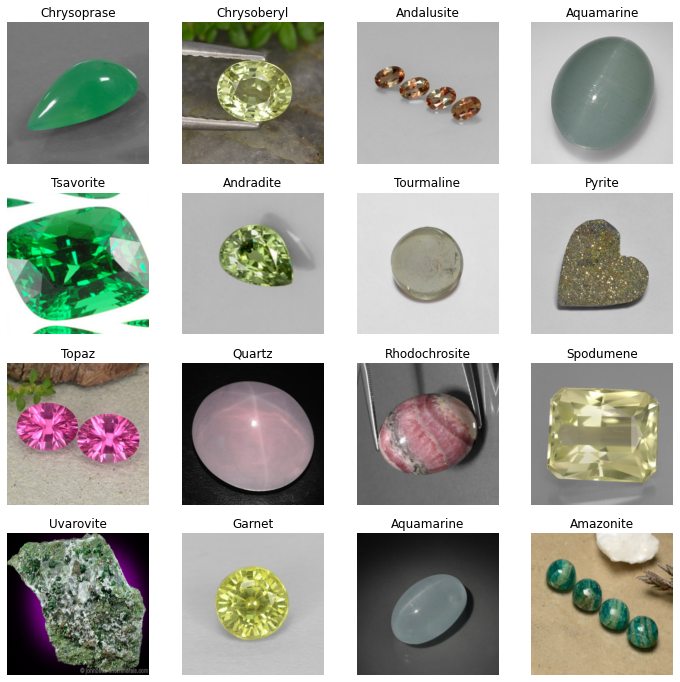

In [11]:
dim = 4
f, ax = plt.subplots(dim, dim, figsize=(12, 12)) 
for i in range(0, dim):
    for j in range(0, dim):
        rnd_number = randint(0, len(images) - 1)
        cl = labels[rnd_number]
        ax[i,j].imshow(images[rnd_number])
        ax[i,j].set_title(cl)
        ax[i,j].axis('off')
fig.tight_layout()
plt.savefig('Gemstones.eps', format='eps')

### Define model

In [12]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(img_w,img_h,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(len(np.unique(labels))))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 75, 75, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 38, 38, 256)      1

### Compile and fit model

In [13]:
AlexNet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

img_w = img_h = 300

train_gen = train_datagen.flow_from_directory(
    directory=image_path + os.sep + "train",
    target_size=(img_w, img_h),
    color_mode="rgb",
    batch_size=32,
    class_mode="sparse",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    directory=image_path + os.sep + "val",
    target_size=(img_w, img_h),
    color_mode="rgb",
    batch_size=32,
    class_mode="sparse",
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    directory=image_path + os.sep + "test",
    target_size=(img_w, img_h),
    color_mode="rgb",
    batch_size=1,
    class_mode="sparse",
    shuffle=False
)

filters = 32      # the dimensionality of the output space
kernel_size = 3   # length of the 2D convolution window
max_pool = 2      # size of the max pooling windows

EPOCHS = 50                                 # while testing you can change it
batch_size = 32                              # number of training samples using in each mini batch during GD (gradient descent) 
iter_per_epoch = train_gen.n//train_gen.batch_size  # each sample will be passed [iter_per_epoch] times during training
val_per_epoch = val_gen.n//val_gen.batch_size     # each sample will be passed [val_per_epoch] times during validation


m = AlexNet.fit(
       train_gen,
       steps_per_epoch = iter_per_epoch,
       epochs=EPOCHS,
       validation_data = val_gen,
       validation_steps = val_per_epoch,
       verbose = 1
    )

print()
print("--- Train finished in %s seconds ---" % (time.time() - start_time))

Found 3462 images belonging to 80 classes.
Found 461 images belonging to 80 classes.
Found 459 images belonging to 80 classes.
Epoch 1/50
108/108 [==============================] - 28s 156ms/step - loss: 3.6979 - accuracy: 0.1388 - val_loss: 5.1885 - val_accuracy: 0.0312
Epoch 2/50
108/108 [==============================] - 16s 152ms/step - loss: 2.8924 - accuracy: 0.2843 - val_loss: 2.9570 - val_accuracy: 0.2701
Epoch 3/50
108/108 [==============================] - 17s 153ms/step - loss: 2.5097 - accuracy: 0.3910 - val_loss: 3.3663 - val_accuracy: 0.2076
Epoch 4/50
108/108 [==============================] - 16s 152ms/step - loss: 2.2433 - accuracy: 0.4499 - val_loss: 3.7232 - val_accuracy: 0.1295
Epoch 5/50
108/108 [==============================] - 16s 151ms/step - loss: 2.0567 - accuracy: 0.4985 - val_loss: 3.2614 - val_accuracy: 0.2946
Epoch 6/50
108/108 [==============================] - 16s 152ms/step - loss: 1.8572 - accuracy: 0.5539 - val_loss: 3.6890 - val_accuracy: 0.1652
Epo

### Plot accuracy and loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


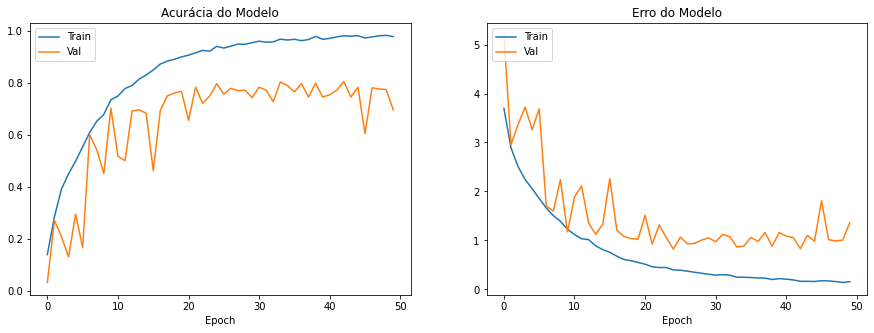

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].plot(m.history['accuracy'])
axs[0].plot(m.history['val_accuracy'])
axs[0].set_title('Acurácia do Modelo')
axs[0].legend(['Treino', 'Validação'], loc='upper left')


axs[1].plot(m.history['loss'])
axs[1].plot(m.history['val_loss'])
axs[1].set_title('Erro do Modelo')
axs[1].legend(['Treino', 'Validação'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Época')

plt.savefig('Accuracy_loss.eps', format='eps')

### Genrating images separated

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


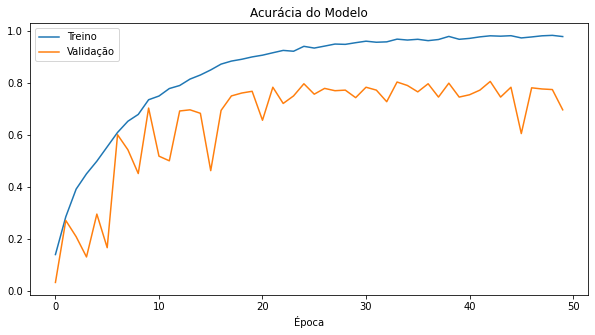

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
axs.plot(m.history['accuracy'])
axs.plot(m.history['val_accuracy'])
axs.set_title('Acurácia do Modelo')
axs.legend(['Treino', 'Validação'], loc='upper left')


# axs.plot(m.history['loss'])
# axs.plot(m.history['val_loss'])
# axs.set_title('Erro do Modelo')
# axs.legend(['Treino', 'Validação'], loc='upper left')


axs.set(xlabel='Época')

plt.savefig('Accuracy.eps', format='eps')
# plt.savefig('Loss.eps', format='eps')

### Make some predictions

In [15]:
iter_per_epoch = test_gen.n // test_gen.batch_size
test_gen.reset()
p = AlexNet.predict(test_gen, steps=iter_per_epoch, verbose=1)

459/459 [==============================] - 3s 5ms/step


### Construct output dataframe

In [16]:
predicted_class_indices = np.argmax(p,axis=1)

labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = test_gen.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

results["Class"] = results["Filename"].str.split('/').str.get(0)
results['Correct'] = results["Class"] == results["Predictions"]
results

,Filename,Predictions,Class,Correct
0,Agate/dendritic-agate-gem-652237a.jpg,Agate,Agate,True
1,Agate/dendritic-agate-gem-652253a.jpg,Agate,Agate,True
2,Agate/dendritic-agate-gem-659441a.jpg,Agate,Agate,True
3,Agate/fire-agate-gem-475799a.jpg,Jasper,Agate,False
4,Agate/fire-agate-gem-487701a.jpg,Jasper,Agate,False
...,...,...,...,...
454,Zoisite/aug_763.png,Zoisite,Zoisite,True
455,Zoisite/aug_774.png,Zoisite,Zoisite,True
456,Zoisite/aug_776.png,Onyx,Zoisite,False
457,Zoisite/aug_779.png,Zoisite,Zoisite,True


### Test accuracy

In [17]:
results["Correct"].sum() / results.shape[0]

0.7145969498910676

### Visual representation of predictions

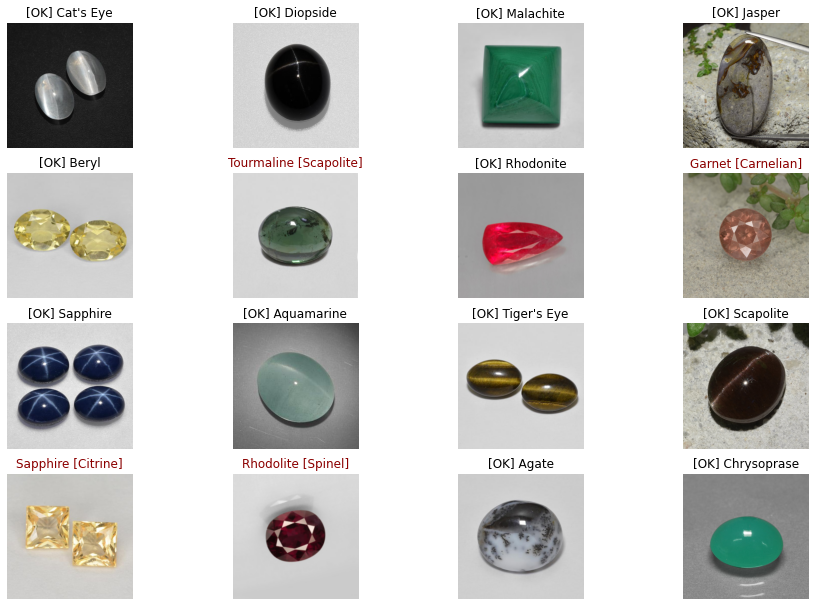

In [26]:
f,ax = plt.subplots(4,4)
f.subplots_adjust(0,0,2,2)
for i in range(0,4,1):
    for j in range(0,4,1):
        rnd_number = randint(0, results.shape[0] - 1)

        image = cv2.imread(image_path + "test/" + results["Filename"][rnd_number])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Show image
        ax[i,j].imshow(image)

        if not(results["Correct"][rnd_number]):
            t = '{} [{}]'.format(results["Class"][rnd_number], results["Predictions"][rnd_number])
            ax[i,j].set_title(t, fontdict={'color': 'darkred'})
        else:
            t = '[OK] {}'.format(results["Class"][rnd_number])
            ax[i,j].set_title(t)
        ax[i,j].axis('off')

plt.savefig('Predict_example.eps', format='eps')

### Save auxiliary files to S3

In [21]:
from zipfile import ZipFile
from pathlib import Path

model_directory = Path("model")

with ZipFile('model.zip', 'w') as myzip:
    for file_path in model_directory.iterdir():
        myzip.write(file_path, arcname=file_path.name)

In [22]:
import shutil

model_directory = 'model'

# Create 'path\to\zip_file.zip'
shutil.make_archive(model_directory, 'zip', model_directory)

'/content/model.zip.zip'

In [40]:
s3_client = boto3.client(
    's3',
    aws_access_key_id = config["S3"]["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key = config["S3"]["AWS_SECRET_ACCESS_KEY"]
)

# Save model locally
AlexNet.save("model")

# Zip model
model_directory = 'model'
shutil.make_archive(model_directory, 'zip', model_directory)

# Upload model to S3
s3_client.upload_file("model.zip", 
                      config["S3"]["BUCKET"], 
                      "model_novo/model.zip")

# Save categorycal enconder locally
with open("gemstone_enc.json", "w") as f:
    json.dump(labels, f)

# Upload file to S3
s3_client.upload_file("gemstone_enc.json", 
                      config["S3"]["BUCKET"], 
                      "model_novo/gemstone_enc.json")

INFO:tensorflow:Assets written to: model/assets
